# Analysis of RNN performance accuracy comparing P, BNP

1. compare R^2 (aggregated preds/labs vs. paired t test)
2. compare accuracies (paired t test)
3. heat map

In [12]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
import statannot
from cryptic_rnn import *


In [40]:
#save_dir = '../results/corrected/addition_trigrams_3inputs_bp_800'
save_dir = '../results/train_2seqs/res_20'
with open(save_dir, 'rb') as f:
    res = pickle.load(f)

# R^2 scores

1. plot prediction against ground truth for all models for the 4 conditions
2. compare individual model r^2 values

In [41]:
############### Functions: R squared comparison ###############

def get_r2_and_preds(mods, tests, hidden_size=20):
    dfs = []
    r2s = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs.append(df) # append data frame of labels and predictions
        r2s.append(r2_score(df['pred'], df['label'])) # individual model r2 score
    all_dfs = pd.concat(dfs)
    all_r2s = r2_score(all_dfs['pred'],all_dfs['label'])
    
    return {'ind_dfs': dfs, 'all_dfs': all_dfs, 'ind_r2s': r2s, 'all_r2s': all_r2s}

def plot_r2s(r2res, ax, train_type=''):
    xy = np.arange(0,40)
    for d in r2res['ind_dfs']:
        ax.scatter(d['label'], d['pred'], alpha = 0.3)
    ax.plot(xy,xy, color='black', linestyle='dashed')
    ax.set_xlabel('Ground truth')
    ax.set_ylabel('Model prediction')
    ax.title.set_text(train_type + ' R^2 = ' + str(round(r2res['all_r2s'], 2)) )
    ax.set_xlim(0,40)
    ax.set_ylim(0,40)
    
##################################
### Plotting
##################################
 
bp_pal = {'Balanced': '#00A7E1', 'Primitives':'#F17720'}
bp_colors = ['#00A7E1', '#F17720']

## plotting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [43]:
hidden_size=20

# extract results
tests = res['tests']
cue_dicts = res['cue_dicts']

mods_b = res['mods_b']
mods_p = res['mods_p']

r2res_p = get_r2_and_preds(mods_p, tests, hidden_size)
r2res_b = get_r2_and_preds(mods_b, tests, hidden_size)

In [44]:
# statistical test:
print('primitives vs balanced', scipy.stats.wilcoxon(r2res_b['ind_r2s'], r2res_p['ind_r2s']))

primitives vs balanced WilcoxonResult(statistic=0.0, pvalue=1.6226417655688113e-112)


### Plot predictions against r2

Text(0.5, 0.94, 'RNN predictions against ground truth')

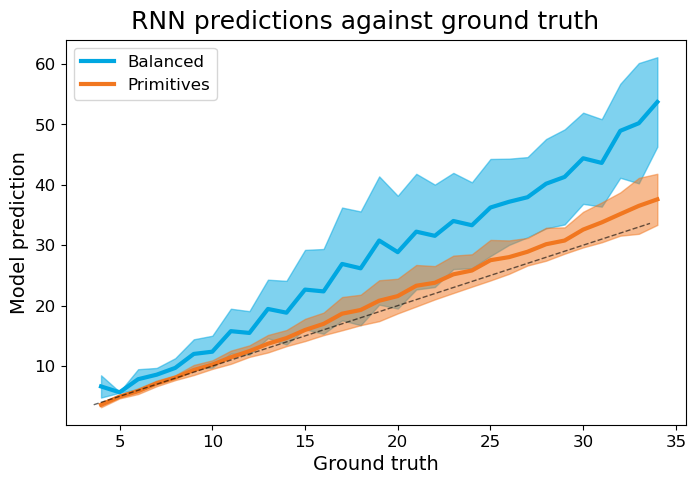

In [45]:
# aggregate all predictions vs labels across models
all_dfs_b = pd.concat(r2res_b['ind_dfs'])
all_dfs_p = pd.concat(r2res_p['ind_dfs'])

labels = ['Balanced', 'Primitives']
plt.rcParams['figure.figsize'] = (8,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),np.max(xvals))
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=1, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('RNN predictions against ground truth', y=0.94)

### Difference in ind r2 scores

In [46]:
r2_b = r2res_b['ind_r2s']
r2_p = r2res_p['ind_r2s']
N = len(r2_b)

r2_scores = r2_b + r2_p
regimes = ['Balanced']*N + ['Primitives']*N
r2_df = {'R squared score': r2_scores, 'Regime': regimes}

x_jitter = np.zeros(N) + np.random.normal(0, 0.1, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: xlabel='Curriculum', ylabel='$R^2$'>,
 [<statannot.StatResult.StatResult at 0x7fb5f1edb6d0>])

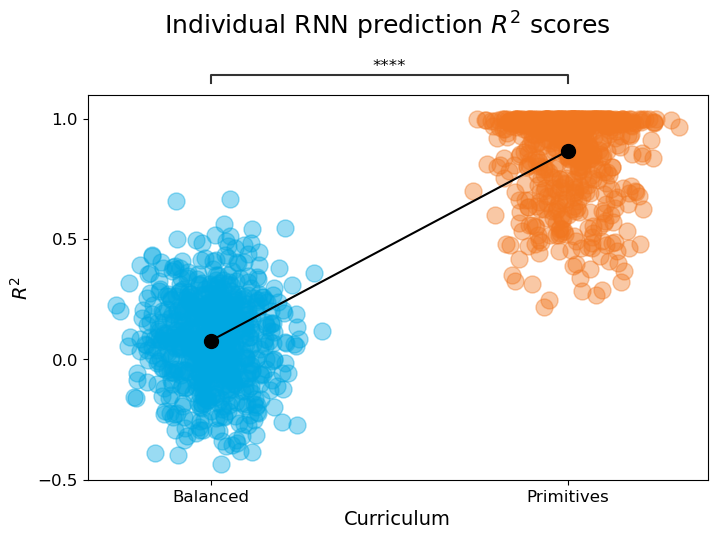

In [47]:
#sns.violinplot(r2_df, x='Regime', y='R squared score', capsize=0.05,errwidth=0.5, palette=bp_pal)

fig, ax = plt.subplots()
ax.scatter(x_jitter, r2_b, color = bp_colors[0], s=150,  alpha=0.4)
ax.scatter(x_jitter+1, r2_p, color = bp_colors[1], s=150,  alpha=0.4)
ax.plot([0,1], [np.mean(r2_b), np.mean(r2_p)], marker='o', color='black', markersize=10)
ax.set_xticks([0,1])
ax.set_xticklabels(['Balanced','Primitives'])
ax.set_xlabel('Curriculum')
ax.set_ylim(-0.5, 1.1)
ax.set_yticks([ -0.5, 0, 0.5, 1])
ax.set_ylabel('$R^2$')
plt.suptitle('Individual RNN prediction $R^2$ scores', y=1.05)

statannot.add_stat_annotation(
    ax,
    data=r2_df,
    x='Regime',
    y='R squared score',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


# MSE analysis

In [48]:
def test_modloss(model, testdata, criterion, hidden_size=20):
    model.eval()
    losses_testset = []
    
    for t in testdata:
        loss_set = 0
        for x,y in t:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                loss_set += criterion(y_hat, torch.tensor([y[i].item()])).item()
     
        losses_testset.append(loss_set)
        
    return losses_testset


def extract_MSELoss(res1):
    tests = res1['tests']
    mods_b = res1['mods_b']
    mods_p = res1['mods_p']
    criterion = nn.MSELoss()
    mse_b = []
    mse_p = []
    for i in range(len(mods_b)):
        mse_b.append(test_modloss(mods_b[i], [tests[i]], criterion, hidden_size)[0]) 
        mse_p.append(test_modloss(mods_p[i], [tests[i]], criterion, hidden_size)[0]) 
        
    return {'mse_b': mse_b, 'mse_p': mse_p}

criterion = nn.MSELoss()

def ind_losses(mods, test_seqs, hidden_size=20, num_classes=22):
    losses = []
    for i, mod in enumerate(mods):
        cuedict = cue_dicts[i]
        testseqs = change_dict(test_seqs, cuedict)
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
        losses.append(test_loss(mod, [testset], criterion)[0])
    return losses


In [49]:
lossres = extract_MSELoss(res)
lossesb = np.sqrt(lossres['mse_b'])
lossesp = np.sqrt(lossres['mse_p'])
curricula = ['Balanced']*len(lossesb) + ['Primitives']*len(lossesp)
rmse = np.append(lossesb, lossesp)

rmse_df = pd.DataFrame({'Curriculum':curricula, 'RMSE':rmse})

N = len(lossesb)
x_jitter = np.repeat([0], N) + np.random.normal(0, 0.1, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: xlabel='Curriculum', ylabel='RMSE'>,
 [<statannot.StatResult.StatResult at 0x7fb5f1ecb790>])

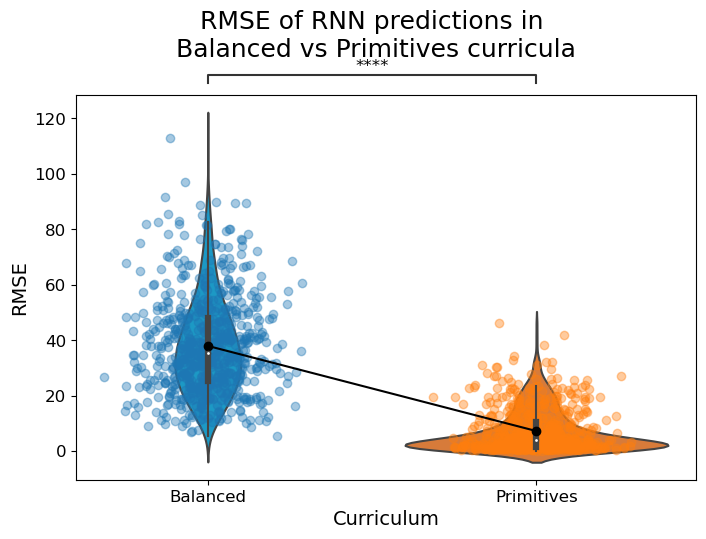

In [50]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6,6)
sns.violinplot(data=rmse_df, x='Curriculum', y='RMSE', capsize=0.1, palette=bp_pal, errwidth=1)

y_p = [np.mean(lossesb), np.mean(lossesp)]
ax.plot([0,1], y_p, color = 'black', marker = 'o')
plt.scatter(x_jitter, lossesb, alpha = 0.4)
plt.scatter(x_jitter+1, lossesp, alpha = 0.4)
plt.suptitle('RMSE of RNN predictions in \nBalanced vs Primitives curricula', y=1.05)

statannot.add_stat_annotation(
    ax,
    data=rmse_df,
    x='Curriculum',
    y='RMSE',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


# Heatmap

In [51]:
reslist = [r2res_p, r2res_b]

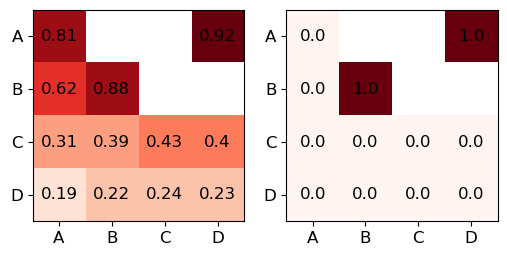

In [52]:
fig, ax = plt.subplots(1,2)
ax = ax.flatten()
for i, r2_res in enumerate(reslist):
    df = r2_res['all_dfs'].groupby('trial').mean()
    heatmap_acc_sign(4, df, ax[i])
#plt.colorbar(cm.ScalarMappable(cmap=cmap), ax = ax, shrink=0.4)

In [ ]:
fig, ax = plt.subplots(1,1)
heatmap_acc_sign(num_inputs, df, ax)

In [51]:
def heatmap_acc_sign(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[1])
        j = map_syms.index(eval(trial)[3])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


In [50]:
new_reds = cm.get_cmap('Reds', 10)
cmap=new_reds

In [92]:
def generate_pos_trials(op, input_ids, init_values, cue_dict, steps = 1):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat= steps))
    combi_ops = list(itertools.product(ops, repeat= steps))
    for init in input_ids:
        for cue in combi_inputcue:
            seq.append([('+',init),
                        *zip(combi_ops[0], cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq


In [95]:
test2step = random.sample(generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2), 10)

In [101]:
cue_dicts = res['cue_dicts']
tests = random.sample(generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2), 10)
test_all = [change_dict(tests, cuedict) for cuedict in cue_dicts]
testsets = []
for t in test_all:
    test_inputs = convert_seq2inputs(t, num_classes=num_classes, seq_len=5)
    testsets.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))

r2res_p2 = get_r2_and_preds(mods_p, testsets)
r2res_b2 = get_r2_and_preds(mods_b, testsets)


Text(0.5, 1, 'Aggregate RNN predictions against ground \ntruth for complex addition')

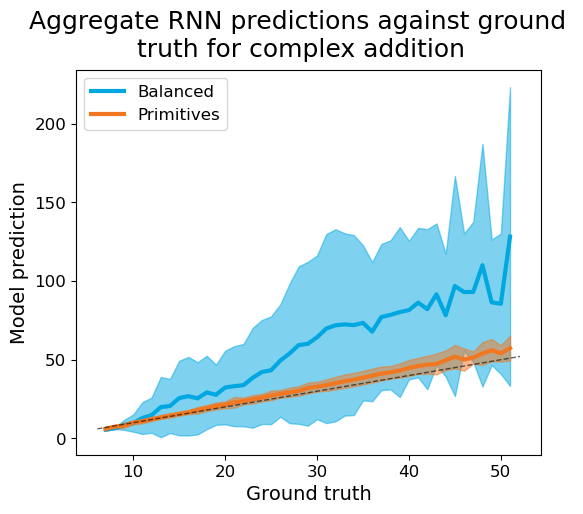

In [112]:
all_dfs_b = pd.concat(r2res_b2['ind_dfs'])
all_dfs_p = pd.concat(r2res_p2['ind_dfs'])

labels = ['Balanced', 'Primitives']
plt.rcParams['figure.figsize'] = (6,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),53)
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=1, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('Aggregate RNN predictions against ground \ntruth for complex addition', y=1)

In [106]:
r2_b = r2res_b2['ind_r2s']
r2_p = r2res_p2['ind_r2s']
N = len(r2_b)

r2_scores = r2_b + r2_p
regimes = ['Balanced']*N + ['Primitives']*N
r2_df = {'R squared score': r2_scores, 'Regime': regimes}

x_jitter = np.zeros(N) + np.random.normal(0, 0.1, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.807e-41 stat=7.265e+04


(<AxesSubplot: ylabel='$R^2$'>,
 [<statannot.StatResult.StatResult at 0x7f81a0cf0310>])

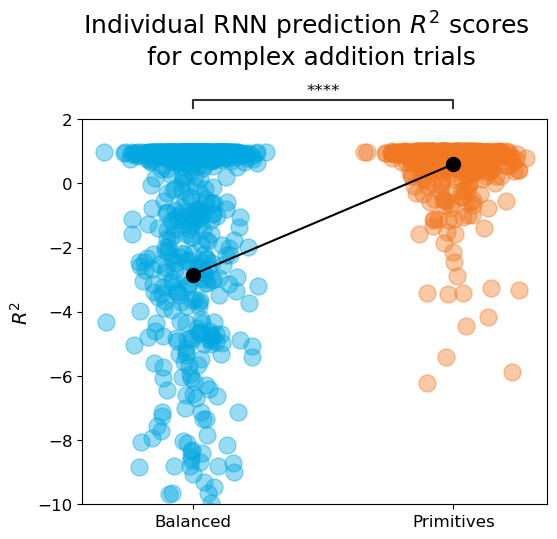

In [115]:
fig, ax = plt.subplots()
ax.scatter(x_jitter, r2_b, color = bp_colors[0], s=150,  alpha=0.4)
ax.scatter(x_jitter+1, r2_p, color = bp_colors[1], s=150,  alpha=0.4)
ax.plot([0,1], [np.mean(r2_b), np.mean(r2_p)], marker='o', color='black', markersize=10)
ax.set_xticks([0,1])
ax.set_xticklabels(['Balanced','Primitives'])
ax.set_ylim(-10,2)
ax.set_ylabel('$R^2$')
plt.suptitle('Individual RNN prediction $R^2$ scores \n for complex addition trials', y=1.1)

statannot.add_stat_annotation(
    ax,
    data=r2_df,
    x='Regime',
    y='R squared score',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


In [119]:
r2s = [0.67, 0.96, -0.1, -0.01]
regime = ['Rich - Balanced', 'Rich - Primitives', 'Lazy - Balanced', 'Lazy - Primitives']

/var/folders/6y/z1h4y1t94jvb186qws4p3qq40000gn/T/ipykernel_29240/3070459264.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(regime, rotation=20)


Text(0.5, 0.98, 'Rich vs Lazy mean $R^2$')

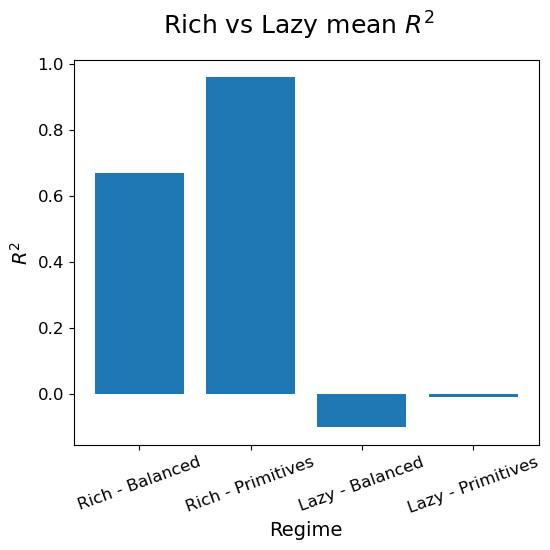

In [131]:
fig, ax = plt.subplots()
ax.bar(x=regime, height = r2s)
ax.set_xticklabels(regime, rotation=20)
ax.set_xlabel('Regime')
ax.set_ylabel('$R^2$')
plt.suptitle('Rich vs Lazy mean $R^2$')